<a href="https://colab.research.google.com/github/duc-ke/kaggle-playground-group/blob/main/7.CT_lung_segmentation/st1_1_train(keras_simpleUnet)_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very simple U-Net training (Keras ver.)
[Colab GPU 환경 셋팅(필수)]
* [런타임] - [런타임유형변경] - [가속기] - GPU 선택 후 저장

In [1]:
!git clone https://github.com/duc-ke/kaggle-playground-group.git

Cloning into 'kaggle-playground-group'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (325/325), done.
remote: Total 407 (delta 194), reused 248 (delta 78), pack-reused 0
Receiving objects: 100% (407/407), 113.98 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (194/194), done.
Checking out files: 100% (76/76), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

# Load Dataset

In [3]:
x_train = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/x_train.npy')
y_train = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/y_train.npy')
x_val = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/x_val.npy')
y_val = np.load('kaggle-playground-group/7.CT_lung_segmentation/dataset/y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


# Build Model

In [4]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

# Train
* ReduceLROnPlateau 콜백 함수
  * factor : lr을 얼마나 감소 시킬지(new_lr = factor * lr)
  * mode : monitor가 최소/최대 중 무엇인지 알려주는 인자. min/max/auto
  * min_lr : lr의 하한선
  * 출처: https://deep-deep-deep.tistory.com/56

In [5]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/100
8/8 [==============================] - 18s 584ms/step - loss: 0.5569 - acc: 0.7606 - mse: 0.1826 - val_loss: 0.5058 - val_acc: 0.7467 - val_mse: 0.1662 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 1s 184ms/step - loss: 0.4758 - acc: 0.7627 - mse: 0.1555 - val_loss: 0.4574 - val_acc: 0.7467 - val_mse: 0.1509 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 1s 184ms/step - loss: 0.4423 - acc: 0.7627 - mse: 0.1456 - val_loss: 0.4823 - val_acc: 0.7467 - val_mse: 0.1662 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 1s 184ms/step - loss: 0.4339 - acc: 0.7621 - mse: 0.1455 - val_loss: 0.4485 - val_acc: 0.7380 - val_mse: 0.1496 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 1s 184ms/step - loss: 0.4169 - acc: 0.7493 - mse: 0.1403 - val_loss: 0.3891 - val_acc: 0.7563 - val_mse: 0.1315 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 1s 185ms/step - loss: 0.3606 - acc: 0.8026 - mse: 0.1191 - val_loss:

# Evaluation

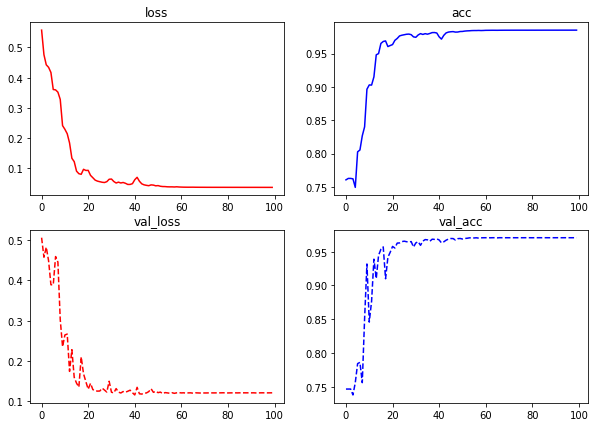

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

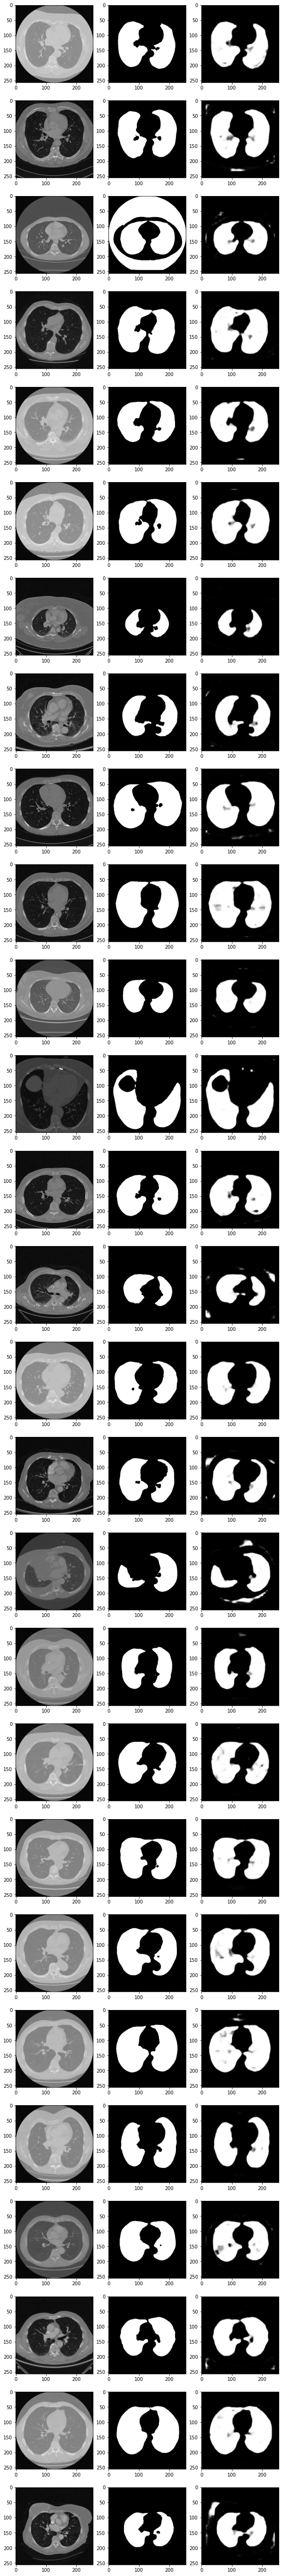

In [7]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')